## Import des packages

In [32]:
from product_sub.infrastructure.dataset_builder import DatasetBuilder
from product_sub.domain.pipeline_creator import PipelineCreator
import product_sub.settings as stg

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, plot_confusion_matrix

from imblearn.over_sampling import SMOTE 


## Import des données et pipelines

In [45]:
dataset_merged = DatasetBuilder(
    filename_bank=stg.FILENAME_BANK, filename_socio=stg.FILENAME_SOCIO_ECO
).create_dataset()
X = dataset_merged.drop(columns=stg.COL_RAW_SUBSCRIPTION)
y = dataset_merged[stg.COL_RAW_SUBSCRIPTION].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=stg.RANDOM_STATE
)

custom_pipeline_accessor = PipelineCreator()
preprocessor = custom_pipeline_accessor.preprocessor

clf = Pipeline(steps=[ ('preprocessor' , preprocessor),
                           ('rf',  RandomForestClassifier()) ])
rf = RandomForestClassifier()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## OverSampling

In [42]:
smt = SMOTE(sampling_strategy=0.4,random_state=stg.RANDOM_STATE)
#X_train, y_train = smt.fit_resample(X_train,y_train)

In [37]:
grid_params_rf = [{
                'criterion': ['entropy','gini'],
                'min_samples_leaf': [40, 80, 100],
                'max_depth': [15,25, 27],
                'min_samples_split': [3, 5, 10],
                'n_estimators' : [60, 70]
                }]
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=stg.RANDOM_STATE)
search = GridSearchCV(rf, grid_params_rf, n_jobs=-1, refit=True)
search.fit(X_train, y_train)
y_train

array([1, 0, 0, ..., 0, 0, 0])

In [38]:
search.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 40,
 'min_samples_split': 3,
 'n_estimators': 60}

In [46]:
##WITH SMOTE

#good_rf = RandomForestClassifier(criterion="entropy", max_depth=15, min_samples_leaf=40, min_samples_split=3, n_estimators=60)
#good_rf.fit(X_train, y_train)

##WITHOUT SMOTE
good_rf = RandomForestClassifier()
good_rf.fit(X_train, y_train)

RandomForestClassifier()

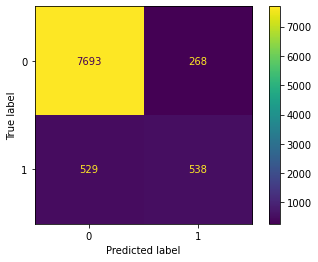

In [47]:
plot_confusion_matrix(good_rf,X_test, y_test)
